# Hyro Failure Analysis (Paths on Desktop)

This notebook:
- Loads **two CSVs** using your exact local paths.
- **Keeps every row** (no deduping or merging of duplicates).
- Ensures the four required columns exist for analysis:
  - `primary_issue_category`
  - `primary_failure_signal`
  - `secondary_issue_category`
  - `secondary_failure_signal`
- Forces blanks in the two **secondary** columns to the literal string `"null"`.
- Runs simple checks to show that **multiple failures can exist within the same conversation**.
- Leaves a final, **run-later** cell for a Tableau-ready export (not executed here).


In [1]:
# --- Use your exact local paths here ---
hyro_path  = "/Users/teitelbaumsair/Desktop/Open-Source-Projects/Hyro Content Evaluation July 2025.csv"
utter_path = "/Users/teitelbaumsair/Desktop/Open-Source-Projects/utterance_with_flags_sample.csv"


## 0) Imports and helpers

In [2]:
import pandas as pd

def read_csv_basic(path):
    return pd.read_csv(path)

def find_column(df, options):
    # match ignoring case/extra spaces
    lower_map = {c.strip().lower(): c for c in df.columns}
    for opt in options:
        key = opt.strip().lower()
        if key in lower_map:
            return lower_map[key]
    return None

def normalize_secondary(series):
    s = series.astype(str).str.strip()
    s = s.replace({"": "null", "nan": "null", "None": "null", "NULL": "null"})
    s = s.fillna("null")
    return s


## 1) Load datasets

We read both CSVs. We **do not** drop duplicates.


In [3]:
# Read both CSVs
eval_df = read_csv_basic(hyro_path)
utter_df = read_csv_basic(utter_path)

print("Evaluation CSV shape:", eval_df.shape)
print("Evaluation CSV columns:", list(eval_df.columns))
print("\nUtterances CSV shape:", utter_df.shape)
print("Utterances CSV columns:", list(utter_df.columns))


Evaluation CSV shape: (100, 8)
Evaluation CSV columns: ['CONVERSATION_ID', 'Conversation Dialogue', 'Primary Issue Category', 'Primary Failure Signal', 'Secondary Issue Category', 'Secondary Failure Signal', 'Criticality', 'Notes']

Utterances CSV shape: (100, 16)
Utterances CSV columns: ['CONVERSATION_ID', 'turn_index', 'speaker', 'utterance_raw', 'utterance', 'char_count', 'word_count', 'utterance_lc', 'didnt_catch', 'say_it_again', 'please_hold', 'transfer_to_agent', 'verify_details', 'ask_zip', 'ask_dob', 'menu_options']


## 2) Ensure required columns exist and are normalized

We find columns by common variants. If a column is missing, we create it.
- For primary fields, empty string is allowed.
- For secondary fields, blanks are converted to the literal `"null"`.


In [4]:
# Common variants
primary_issue_opts = ["primary_issue_category","primary issue category","primary_issue","primary issue"]
primary_signal_opts = ["primary_failure_signal","primary failure signal","primary_signal","primary signal"]
secondary_issue_opts = ["secondary_issue_category","secondary issue category","secondary_issue","secondary issue"]
secondary_signal_opts = ["secondary_failure_signal","secondary failure signal","secondary_signal","secondary signal"]

def ensure_required_columns(df):
    c_primary_issue = find_column(df, primary_issue_opts)
    c_primary_signal = find_column(df, primary_signal_opts)
    c_secondary_issue = find_column(df, secondary_issue_opts)
    c_secondary_signal = find_column(df, secondary_signal_opts)

    # Create missing columns (primary can be empty; secondary must be 'null' when blank)
    if c_primary_issue is None:
        df["primary_issue_category"] = ""
        c_primary_issue = "primary_issue_category"
    if c_primary_signal is None:
        df["primary_failure_signal"] = ""
        c_primary_signal = "primary_failure_signal"
    if c_secondary_issue is None:
        df["secondary_issue_category"] = "null"
        c_secondary_issue = "secondary_issue_category"
    if c_secondary_signal is None:
        df["secondary_failure_signal"] = "null"
        c_secondary_signal = "secondary_failure_signal"

    # Canonical columns
    df["primary_issue_category"]   = df[c_primary_issue].astype(str).str.strip()
    df["primary_failure_signal"]   = df[c_primary_signal].astype(str).str.strip()
    df["secondary_issue_category"] = normalize_secondary(df[c_secondary_issue])
    df["secondary_failure_signal"] = normalize_secondary(df[c_secondary_signal])

    return df

eval_df = ensure_required_columns(eval_df)
utter_df = ensure_required_columns(utter_df)

print("Evaluation required cols preview:")
print(eval_df[["primary_issue_category","primary_failure_signal","secondary_issue_category","secondary_failure_signal"]].head())

print("\nUtterances required cols preview:")
print(utter_df[["primary_issue_category","primary_failure_signal","secondary_issue_category","secondary_failure_signal"]].head())


Evaluation required cols preview:
          primary_issue_category                primary_failure_signal  \
0   Conversation-Level Red Flags  Conversation ends without resolution   
1   Conversation-Level Red Flags  Conversation ends without resolution   
2  Software / Technical Failures               Slot availability crash   
3   NLU (Understanding) Failures                            Menu loops   
4  Software / Technical Failures                     Verification loop   

       secondary_issue_category  secondary_failure_signal  
0  Conversation-Level Red Flags  Escalation after success  
1                          null                      null  
2  Conversation-Level Red Flags  Escalation after success  
3  Conversation-Level Red Flags  Escalation after success  
4  Conversation-Level Red Flags  Escalation after success  

Utterances required cols preview:
  primary_issue_category primary_failure_signal secondary_issue_category  \
0                                                 

## 3)Join for analysis

If both files share a conversation identifier, we can **optionally** join them for richer analysis.
We try to detect a conversation id column by common names. If not found in both, we skip merging and just analyze `eval_df`.


In [5]:
# Try to detect a conversation id column in each
conv_opts = ["conversation_id","conversation id","conv_id","id"]

def detect_conv_col(df):
    lower_map = {c.strip().lower(): c for c in df.columns}
    for name in conv_opts:
        if name in lower_map:
            return lower_map[name]
    return None

eval_conv = detect_conv_col(eval_df)
utt_conv  = detect_conv_col(utter_df)

if eval_conv and utt_conv:
    merged = eval_df.merge(utter_df, left_on=eval_conv, right_on=utt_conv, how="left", suffixes=("_eval","_utt"))
    print("Merged on", eval_conv, "<->", utt_conv, "shape:", merged.shape)
else:
    merged = eval_df.copy()
    print("Merge skipped (no common conversation id). Using eval_df only. Shape:", merged.shape)

# For downstream analysis, ensure the **canonical** columns exist on merged as well
merged = ensure_required_columns(merged)

print("\nMerged required cols preview:")
print(merged[["primary_issue_category","primary_failure_signal","secondary_issue_category","secondary_failure_signal"]].head())


Merged on CONVERSATION_ID <-> CONVERSATION_ID shape: (100, 31)

Merged required cols preview:
          primary_issue_category                primary_failure_signal  \
0   Conversation-Level Red Flags  Conversation ends without resolution   
1   Conversation-Level Red Flags  Conversation ends without resolution   
2  Software / Technical Failures               Slot availability crash   
3   NLU (Understanding) Failures                            Menu loops   
4  Software / Technical Failures                     Verification loop   

       secondary_issue_category  secondary_failure_signal  
0  Conversation-Level Red Flags  Escalation after success  
1                          null                      null  
2  Conversation-Level Red Flags  Escalation after success  
3  Conversation-Level Red Flags  Escalation after success  
4  Conversation-Level Red Flags  Escalation after success  


## 4) Simple analyses (keep every row)

We **do not** dedupe. The goal is to show that multiple failures can exist inside the same conversation.


In [6]:
# Count exact combinations across all rows
combo_counts = (
    merged.groupby(["primary_issue_category","primary_failure_signal",
                    "secondary_issue_category","secondary_failure_signal"])
          .size()
          .reset_index(name="row_count")
          .sort_values("row_count", ascending=False)
)
print("Top 10 failure combinations:")
print(combo_counts.head(10))

# Per-conversation summary: how many unique failure combinations?
conv_col = detect_conv_col(merged)
if conv_col:
    combo_per_conv = (
        merged.groupby([conv_col,"primary_issue_category","primary_failure_signal",
                        "secondary_issue_category","secondary_failure_signal"])
              .size()
              .reset_index(name="rows_for_this_combo")
    )
    combos_summary = combo_per_conv.groupby(conv_col).size().reset_index(name="num_unique_failure_combos")
    print("\nUnique failure combos per conversation (first 10):")
    print(combos_summary.head(10))

    # Show examples where there are multiple combos for the same conversation
    multi = combos_summary[combos_summary["num_unique_failure_combos"] > 1]
    print("\nConversations with >1 unique failure combo (first 10):")
    print(multi.head(10))
else:
    print("\nNo conversation id detected; skipping per-conversation combo summary.")


Top 10 failure combinations:
           primary_issue_category                primary_failure_signal  \
33  Software / Technical Failures               Slot availability crash   
5    Conversation-Level Red Flags              Escalation after success   
4    Conversation-Level Red Flags  Conversation ends without resolution   
21   NLU (Understanding) Failures        Repeated clarification prompts   
24   NLU (Understanding) Failures        Repeated clarification prompts   
35  Software / Technical Failures               Slot availability crash   
34  Software / Technical Failures               Slot availability crash   
29   NLU (Understanding) Failures               Slot availability crash   
23   NLU (Understanding) Failures        Repeated clarification prompts   
25   NLU (Understanding) Failures        Repeated clarification prompts   

         secondary_issue_category                secondary_failure_signal  \
33   Conversation-Level Red Flags                Escalation after su

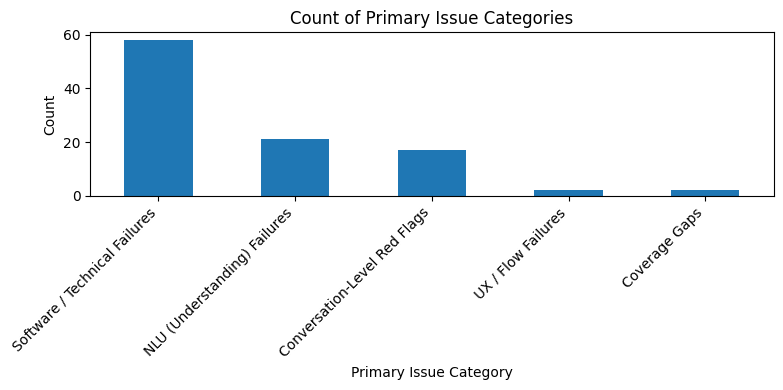

In [8]:
import matplotlib.pyplot as plt

# Bar chart: Primary Issue Categories
plt.figure(figsize=(8,4))
eval_df["primary_issue_category"].value_counts().plot(kind="bar")
plt.title("Count of Primary Issue Categories")
plt.xlabel("Primary Issue Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

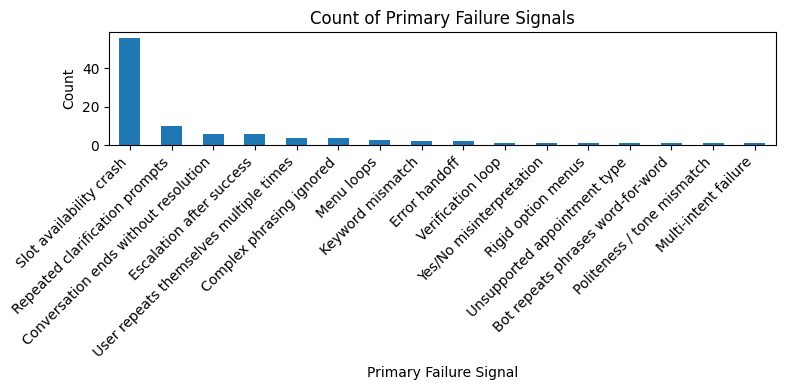

In [9]:
# Bar chart: Primary Failure Signals
plt.figure(figsize=(8,4))
eval_df["primary_failure_signal"].value_counts().plot(kind="bar")
plt.title("Count of Primary Failure Signals")
plt.xlabel("Primary Failure Signal")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

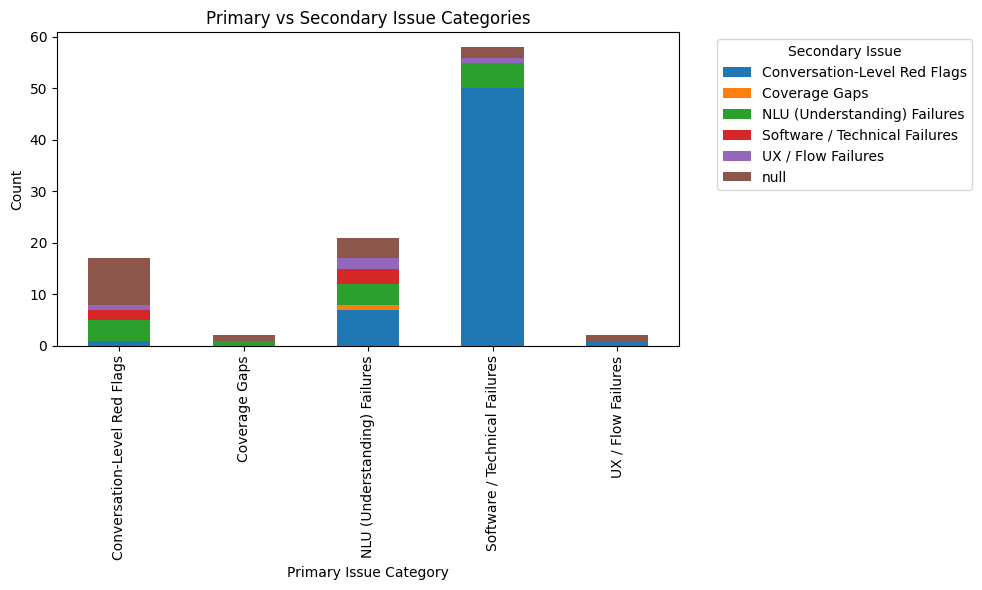

In [10]:

# Stacked bar chart: Primary vs Secondary Issue Categories
plt.figure(figsize=(8,5))
cross_tab = pd.crosstab(eval_df["primary_issue_category"], eval_df["secondary_issue_category"])
cross_tab.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Primary vs Secondary Issue Categories")
plt.xlabel("Primary Issue Category")
plt.ylabel("Count")
plt.legend(title="Secondary Issue", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [16]:
# ============================
# Visualization Bundle (Basic)
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 0) Helpers (safe no-ops if already defined) ----
def _safe_detect_conv_col(df):
    try:
        return detect_conv_col(df)
    except NameError:
        opts = ["conversation_id","conversation id","conv_id","id"]
        lower_map = {c.strip().lower(): c for c in df.columns}
        for name in opts:
            if name in lower_map: return lower_map[name]
        return None

def _safe_find_column(df, options):
    try:
        return find_column(df, options)
    except NameError:
        lower_map = {c.strip().lower(): c for c in df.columns}
        for opt in options:
            key = opt.strip().lower()
            if key in lower_map: return lower_map[key]
        return None

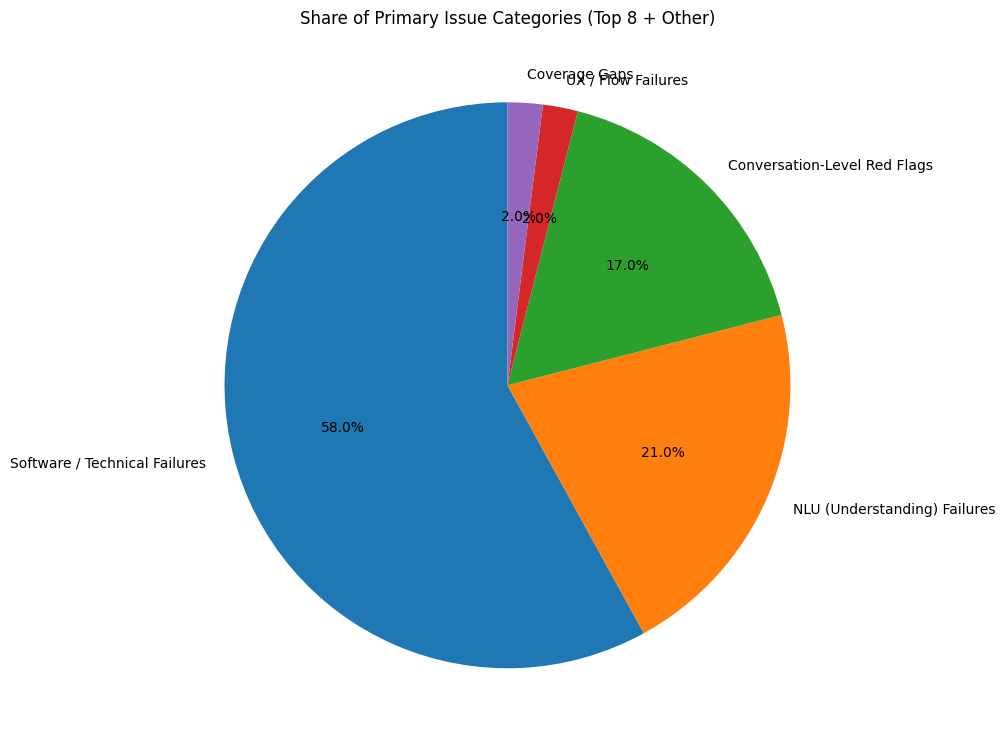

In [25]:
# A1) Pie/Donut: share of Primary Issue Categories (top 8 + "Other")
counts = eval_df["primary_issue_category"].value_counts()
top8 = counts.head(8)
other = counts.iloc[8:].sum()
labels = list(top8.index) + (["Other"] if other > 0 else [])
sizes  = list(top8.values) + ([other] if other > 0 else [])

plt.figure(figsize=(10,10))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Share of Primary Issue Categories (Top 8 + Other)")
plt.tight_layout()
plt.show()

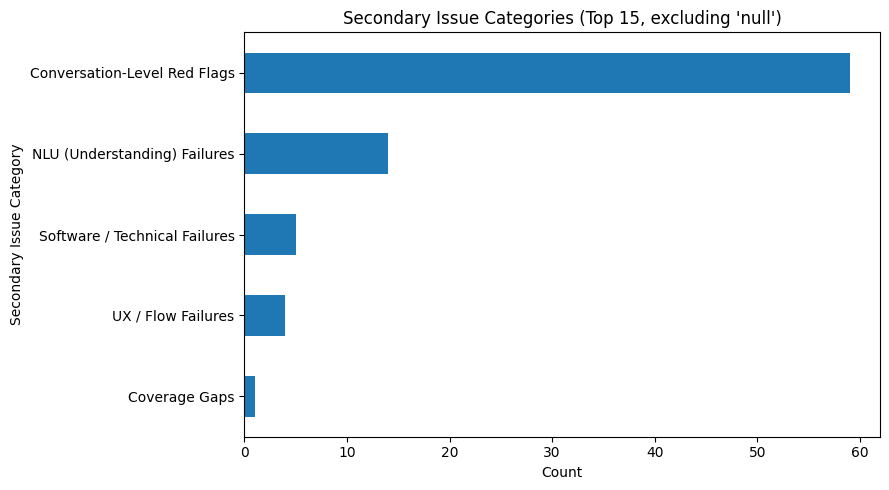

In [26]:
# A2) Horizontal bar: Secondary Issue Categories (exclude literal "null" to see real secondaries)
sec_counts = eval_df["secondary_issue_category"].replace("null", np.nan).dropna().value_counts().head(15)
plt.figure(figsize=(9,5))
sec_counts.sort_values().plot(kind="barh")
plt.title("Secondary Issue Categories (Top 15, excluding 'null')")
plt.xlabel("Count")
plt.ylabel("Secondary Issue Category")
plt.tight_layout()
plt.show()

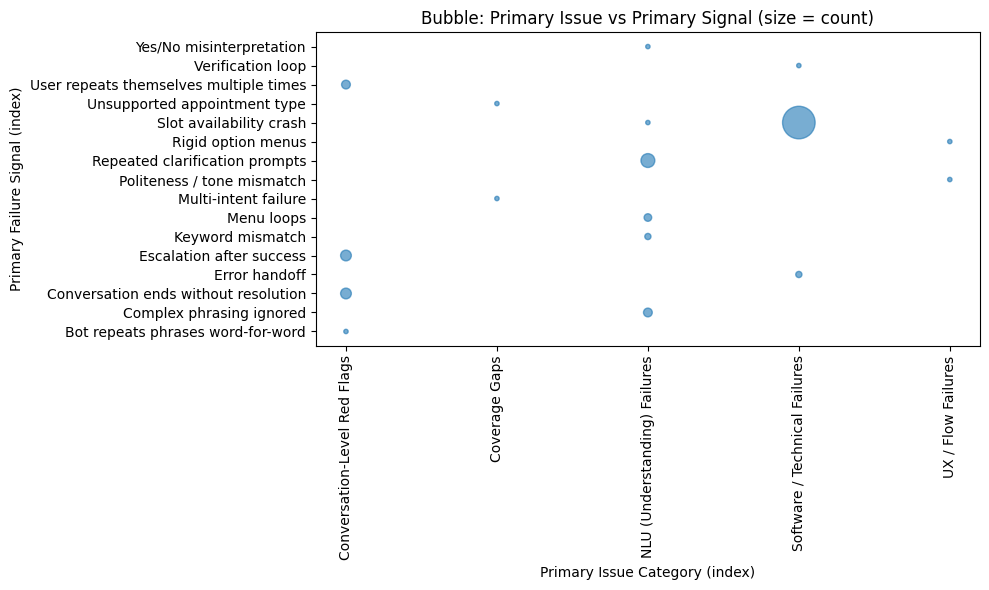

In [27]:
# B1) Bubble chart: (Primary Issue, Primary Signal) sized by count
pair_counts = (
    eval_df.groupby(["primary_issue_category","primary_failure_signal"])
           .size().reset_index(name="count")
)
# map categories to indices so we can scatter
issues = pair_counts["primary_issue_category"].astype(str).unique()
signals = pair_counts["primary_failure_signal"].astype(str).unique()
issue_to_x = {v:i for i,v in enumerate(sorted(issues))}
sig_to_y   = {v:i for i,v in enumerate(sorted(signals))}
xs = pair_counts["primary_issue_category"].map(issue_to_x)
ys = pair_counts["primary_failure_signal"].map(sig_to_y)

plt.figure(figsize=(10,6))
plt.scatter(xs, ys, s=pair_counts["count"]*10, alpha=0.6)
plt.title("Bubble: Primary Issue vs Primary Signal (size = count)")
plt.xlabel("Primary Issue Category (index)")
plt.ylabel("Primary Failure Signal (index)")
plt.xticks(ticks=list(issue_to_x.values()), labels=list(issue_to_x.keys()), rotation=90)
plt.yticks(ticks=list(sig_to_y.values()), labels=list(sig_to_y.keys()))
plt.tight_layout()
plt.show()


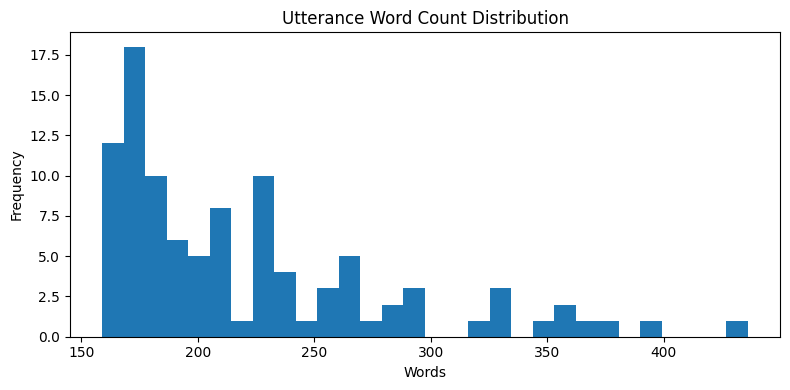

In [28]:
utter_col = _safe_find_column(merged, ["utterance_slim","utterance slim","utterance","text","agent_text","bot_text"])
if utter_col:
    # E1) Histogram of word counts
    word_counts = merged[utter_col].astype(str).str.split().apply(len)
    plt.figure(figsize=(8,4))
    plt.hist(word_counts.dropna(), bins=30)
    plt.title("Utterance Word Count Distribution")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


## 5) (Run later) Export for Tableau

When you are ready to export, you can run the cell below. It keeps every row and ensures the four columns exist.
**This cell is intentionally not executed here.**


In [31]:
# Uncomment and set the path you want, then run.
TABLEAU_EXPORT_PATH = "/Users/teitelbaumsair/Desktop/Open-Source-Projects/hyro_tableau_export.csv"

export_cols = []
conv_col = detect_conv_col(merged)
if conv_col:
    export_cols.append(conv_col)
export_cols += [
    "primary_issue_category",
    "primary_failure_signal",
    "secondary_issue_category",
    "secondary_failure_signal",
    "Criticality",
]
export_cols = [c for c in export_cols if c in merged.columns]

tableau_df = merged[export_cols].copy()
# Safety: enforce "null" on secondaries again
tableau_df["secondary_issue_category"] = normalize_secondary(tableau_df["secondary_issue_category"])
tableau_df["secondary_failure_signal"] = normalize_secondary(tableau_df["secondary_failure_signal"])

tableau_df.to_csv(TABLEAU_EXPORT_PATH, index=False)
print("Saved Tableau CSV to:", TABLEAU_EXPORT_PATH)


Saved Tableau CSV to: /Users/teitelbaumsair/Desktop/Open-Source-Projects/hyro_tableau_export.csv
